In [1]:
import tensorflow as tf

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

import os
import datetime

In [293]:
def generate_ex1(N, seed=int(datetime.datetime.now().timestamp())):
    '''
    Generate data for Example 1.

    Input:
        n: Time-series length

    Returns:
        A Pandas DataFrame
    '''
    # Set random seed
    np.random.seed(seed)
    
    # Define an empty dict
    ex = {}
    
    # Convert n to int
    N = int(N)

    # Generate source variables
    ex['X'] = np.random.normal(0, 1, size=(N,))
    ex['v1'] = np.random.normal(0, 0.1, size=(N,))
    ex['v2'] = np.random.normal(0, 0.1, size=(N,))

    # Initialise dependent variables
    ex['Y'] = np.zeros((N,))
    ex['Y'][0] = 3.2
    ex['Z'] = np.zeros((N,))

    # Generate dependent variables
    for k in range(N - 1):
        ex['Y'][k + 1] = 0.8 * ex['X'][k] + 0.5 * ex['Y'][k] + ex['v1'][k]
        ex['Z'][k + 1] = 0.6 * ex['Y'][k] + ex['v2'][k]
        
    return pd.DataFrame(ex)

def generate_ex2(N, seed=int(datetime.datetime.now().timestamp())):
    '''
    Generate data for Example 2.

    Input:
        n: Time-series length

    Returns:
        A Pandas DataFrame
    '''
    # Set random seed
    np.random.seed(seed)
    
    # Define an empty dict
    ex = {}
    
    # Convert n to int
    N = int(N)

    # Generate source variables
    ex['X'] = np.random.uniform(4, 5, size=(N,))
    ex['v1'] = np.random.normal(0, 0.05, size=(N,))
    ex['v2'] = np.random.normal(0, 0.05, size=(N,))

    # Initialise dependent variables
    ex['Y'] = np.zeros((N,))
    ex['Y'][0] = 0.2
    ex['Z'] = np.zeros((N,))

    # Generate dependent variables
    for k in range(N - 1):
        ex['Y'][k + 1] = 1 - 2 * abs(0.5 - (0.8 * ex['X'][k] + 0.4 * (abs(ex['Y'][k])**0.5))) + ex['v1'][k]
        ex['Z'][k + 1] = 5 * (ex['Y'][k] + 7.2)**2 + 10 * (abs(ex['X'][k])**0.5) + ex['v2'][k]
        
    return pd.DataFrame(ex)

def generate_ex3():
    '''
    Create a DataFrame based on pre-simulated data.
    '''
    return pd.read_csv('.././Data/ex3.csv', delimiter=',')

def create_dataset(df, var, max_lag):
    '''
    Create X and Y for a var, based on a df. 
    X values will be selected up to `max_lag`. 
    
    Returns:
        X: Input data of shape (m, p * max_lag)
        Y: Output labels of shape (m,).
    '''
    assert var in df.columns
    
    # Reverse df rows. This makes going down 
    # the rows to be going back in time. 
    df = df[::-1]
    
    # Obtain output label
    Y = np.array(df[var][:-(max_lag + 1)])
    
    # Create input data
    X = np.vstack([df[(i + 1):(max_lag + i + 1)].values.T.reshape(-1) for i in range(len(df) - 1 - max_lag)])
    
    return X, Y

def var_heatmap(W, max_lag=MAX_LAG):
    '''
    Using Matplotlib, create a heatmap plot 
    of the L2-norm of weights associated with each input
    to the first hidden layer. 
    
    The colourscale spans maps the colour white
    to 0 and the colour black to the maximum
    L2-norm of weights.
    
    Inputs:
        W: Hidden layer weights of size 
           ((p * K) x n_H)
    '''
    # Retrive the weights of the first
    # hidden layer, (p * K) x n_H
    
    # Reshape weights
#     W1 = W1.reshape(-1, MAX_LAG * W1.shape[1])
    
    # Compute the L2-norm of W1 of size K x p
    W_norms = np.linalg.norm(W, axis=1).reshape(MAX_LAG, -1, order='F')
    
    # Display heatmap
    plt.imshow(W_norms, cmap='Greys')
    
    # Set white to 0
    plt.clim(vmin=0)
    
    # Pause to allow for heatmaps to be displayed
    # sequentially in a loop
    plt.pause(0.001)
    
def _extract_weights(W1, max_lag=MAX_LAG):
    '''
    Extract weights from W1 of size ((p * K) x n_H) 
    by computing the L2-norm for each weight along 
    the n_H axis.
    
    Returns:
        A np array of size p x K.
    '''
    # Compute the L2-normof W1 of size K x p
    W1_norm = np.linalg.norm(W1, axis=1).reshape(-1, MAX_LAG, order='C')
    
    return W1_norm

In [111]:
def _L1_regularizer(W1, lambda_):
    return lambda_ * tf.reduce_sum(tf.abs(W1))

def _hierarchical_L1_regularizer(W1, lambda_):
    # Infer dimensions of W1
    _p_times_lag, n_H = W1.shape.as_list()
    p = _p_times_lag // MAX_LAG
    
    # Reshape W1
    _W1 = tf.reshape(W1, shape=(-1, MAX_LAG, W1.shape.as_list()[1]))
    
    # Optimization to parallelize over W1[:, k:, :] for k in range(K)
    _W1 = tf.concat([_W1 * np.concatenate([np.zeros(shape=(p, k, n_H)), 
                                           np.ones(shape=(p, MAX_LAG - k, n_H))], axis=1) \
                     for k in range(MAX_LAG)], axis=0)
    
    return lambda_ * tf.reduce_sum(tf.abs(_W1))

def _L2_regularizer(W1, lambda_):
    return lambda_ * tf.reduce_sum(tf.sqrt(tf.reduce_sum(W1**2, axis=-1)))
    
def _group_L2_regularizer(W1, lambda_):
    return lambda_ * tf.reduce_sum(tf.sqrt(tf.reduce_sum(tf.reduce_sum(W1**2, axis=-1), axis=-1)))

def _hierarchical_L2_regularizer(W1, lambda_):
    # Infer dimensions of W1
    _p_times_lag, n_H = W1.shape.as_list()
    p = _p_times_lag // MAX_LAG
    
    # Reshape W1
    _W1 = tf.reshape(W1, shape=(-1, MAX_LAG, W1.shape.as_list()[1]))
    
    # Optimization to parallelize over W1[:, k:, :] for k in range(K)
    _W1 = tf.concat([_W1 * np.concatenate([np.zeros(shape=(p, k, n_H)), 
                                           np.ones(shape=(p, MAX_LAG - k, n_H))], axis=1) \
                     for k in range(MAX_LAG)], axis=0)
    
    return lambda_ * tf.reduce_sum(tf.sqrt(tf.reduce_sum(tf.reduce_sum(_W1**2, axis=-1), axis=-1)))

In [295]:
def build_FCNN(input_shape, lambda_, reg_type):
    n_H = [20, 20]
    
    reg_func = {
        'L1': _L1_regularizer,
        'L2': _L2_regularizer,
        'g': _group_lasso_regularizer,
        'h': _hierarchical_regularizer,
        'hL1': _hierarchical_L1_regularizer
    }
    
    _X = tf.placeholder(tf.float32, shape=(None, *input_shape), name='X')
    _Y = tf.placeholder(tf.float32, shape=(None, 1), name='Y')
    
    with tf.variable_scope('LAYER1'):
        W1 = tf.Variable(tf.random_normal((_X.get_shape().as_list()[1], n_H[0])), name='W1')
        b1 = tf.Variable(tf.random_normal((1, n_H[0])), name='b1')
        ACT1 = tf.nn.relu(tf.matmul(_X, W1) + b1, name='ACTV1')
        
#     with tf.variable_scope('LAYER1'):
#         W2 = tf.Variable(tf.random_normal((n_H[0], n_H[1])), name='W2')
#         b2 = tf.Variable(tf.random_normal((1, n_H[1])), name='b2')
#         _X = tf.nn.relu(tf.matmul(_X, W2) + b2, name='ACTV2')
        
    with tf.variable_scope('OUTPUT'):
        W_out = tf.Variable(tf.random_normal((n_H[0], _Y.get_shape().as_list()[1])), name='W_OUTPUT')
        b_out = tf.Variable(tf.random_normal((1, 1)), name='b_OUTPUT')
        Y_pred = tf.matmul(ACT1, W_out) + b_out
        
    cost = 0.
    cost += tf.reduce_mean((_Y - Y_pred)**2)
    
    # Add regularizer
    cost += reg_func[reg_type](W1, lambda_)
    
    opt = tf.train.AdamOptimizer().minimize(cost)
    
    return _X, _Y, W1, opt

def build_FCNN_2_layers(input_shape, lambda_, reg_type):
    
    n_H = [20, 20]
    
    reg_func = {
        'L1': _L1_regularizer,
        'L2': _L2_regularizer,
        'gL2': _group_L2_regularizer,
        'hL2': _hierarchical_L2_regularizer,
        'hL1': _hierarchical_L1_regularizer
    }
    
    _X = tf.placeholder(tf.float32, shape=(None, *input_shape), name='X')
    _Y = tf.placeholder(tf.float32, shape=(None, 1), name='Y')
    
    for layer in range(len(n_H)):
        with tf.variable_scope('LAYER{}'.format(layer)):
            W1 = tf.Variable(tf.random_normal((_X.get_shape().as_list()[1], n_H[0])), name='W1')
            b1 = tf.Variable(tf.random_normal((1, n_H[0])), name='b1')
            ACT1 = tf.nn.relu(tf.matmul(_X, W1) + b1, name='ACTV1')
        
    with tf.variable_scope('LAYER2'):
        W2 = tf.Variable(tf.random_normal((n_H[0], n_H[1])), name='W2')
        b2 = tf.Variable(tf.random_normal((1, n_H[1])), name='b2')
        ACT2 = tf.nn.relu(tf.matmul(ACT1, W2) + b2, name='ACTV2')
        
    with tf.variable_scope('OUTPUT'):
        W_out = tf.Variable(tf.random_normal((n_H[0], _Y.get_shape().as_list()[1])), name='W_OUTPUT')
        b_out = tf.Variable(tf.random_normal((1, 1)), name='b_OUTPUT')
        Y_pred = tf.matmul(ACT2, W_out) + b_out
        
    cost = 0.
    cost += tf.reduce_mean((_Y - Y_pred)**2)
    
    # Add regularizer
    cost += reg_func[reg_type](W1, lambda_)
    
    opt = tf.train.AdamOptimizer().minimize(cost)
    
    return _X, _Y, W1, opt

def NN_causality(df, lambda_, reg_type, max_lag, epochs=2000, batch_size=100, use_two_hidden_layers=False):
    # Infer number of variables
    p = len(df.columns)
    
    # Create empty causality array
    W = []
    
    for (i, var) in enumerate(df.columns):
        print('Computing causality of {} (variable {} of {})...'.format(var, i + 1, p))
        
        # Obtain data and target for NN
        X, Y = create_dataset(df, var, max_lag)
        
        # Reset default graph
        tf.reset_default_graph()

        with tf.Session() as sess:
            # Build FCNN
            build_FCNN_func = build_FCNN_2_layers if use_two_hidden_layers else build_FCNN
            _X, _Y, W1, optimizer = build_FCNN_func(X[0].shape, lambda_, reg_type)

            tf.global_variables_initializer().run()
            
            # Train FCNN
            for epoch in range(epochs):
                for batch in range(len(X) // batch_size):
                    sess.run([optimizer], feed_dict={
                        _X: X[(batch * batch_size):((batch + 1) * batch_size)], 
                        _Y: Y[(batch * batch_size):((batch + 1) * batch_size)][:, np.newaxis]
                    })
            
            # Obtain weights and append to main array
            W1_ = sess.run(W1)
            W.append(_extract_weights(W1_, max_lag=MAX_LAG))
            
    # Create a np array from W
    W = np.array(W)
    
    return W

def causality_heatmap(W, df, mode, ord=2):
    '''
    Visualise calculated weights as 
    a heatmap.
    
    When mode is 'joint', it outputs a 
    (p_effect x p_cause) heatmap. When it 
    mode is 'ind', it produces a (p_cause x K) 
    heatmap for each individual p_effect.
    
    Inputs:
        W:    A np array of size (p_effect x p_cause x K)
        df:   A pd dataframe containing column labels
        mode: Visualisation mode {'joint', 'ind'}
        
    Returns:
        A plt heatmap.
    '''
    assert mode in ['joint', 'ind']
    
    # Infer dimensions
    p, K = W[0].shape
    
    if mode == 'joint':
        # Calculate norm on axis 2
        _W_norm = np.linalg.norm(W, ord=ord, axis=2)
        
        # Visualise causality
        plt.imshow(_W_norm, cmap='Greys')
        plt.xlabel('Cause')
        plt.xticks(range(p), df.columns)
        plt.ylabel('Response')
        plt.yticks(range(p), df.columns)
        ax = plt.gca()
        ax.xaxis.set_label_position('top')
        ax.xaxis.tick_top()
        
        # Set white to 0
        plt.clim(vmin=0)
        
    elif mode == 'ind':
        for (var, row) in zip(df.columns, W):
            print('Calculated causes to {}(t)'.format(var))
            plt.imshow(row.T, cmap='Greys')
            plt.xlabel('Cause')
            plt.xticks(range(p), df.columns)
            plt.ylabel('Time Lag')
            plt.yticks(range(K), range(1, K + 1))
            ax = plt.gca()
            ax.xaxis.set_label_position('top')
            ax.xaxis.tick_top()
            
            # Set white to 0
            plt.clim(vmin=0, vmax=np.max(W))
    
            plt.pause(0.001)

###  Example 1

In [296]:
MAX_LAG = 20
ex1 = generate_ex1(1000).iloc[:, :3]

In [297]:
W_ex1 = NN_causality(ex1, lambda_=np.exp(-2), reg_type='h', max_lag=MAX_LAG, batch_size=100)

Computing causality of X (variable 1 of 3)...
Computing causality of Y (variable 2 of 3)...
Computing causality of Z (variable 3 of 3)...


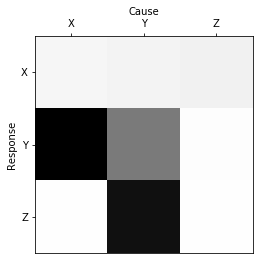

In [298]:
causality_heatmap(W_ex1, ex1, 'joint', 2)

Calculated causes to X(t)


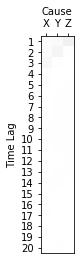

Calculated causes to Y(t)


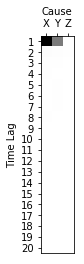

Calculated causes to Z(t)


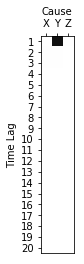

In [299]:
causality_heatmap(W_ex1, ex1, 'ind', 2)

In [301]:
W_ex1_ = NN_causality(ex1, lambda_=np.exp(-2), reg_type='h', max_lag=MAX_LAG, batch_size=100)

Computing causality of X (variable 1 of 3)...
Computing causality of Y (variable 2 of 3)...
Computing causality of Z (variable 3 of 3)...


In [302]:
np.sum(W_ex1_ - W_ex1)

0.010583438

In [303]:
W_ex1 = NN_causality(ex1, lambda_=np.exp(-2), reg_type='h', max_lag=MAX_LAG, batch_size=100, use_two_hidden_layers=True)

Computing causality of X (variable 1 of 3)...
Computing causality of Y (variable 2 of 3)...
Computing causality of Z (variable 3 of 3)...


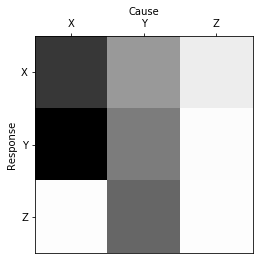

In [304]:
causality_heatmap(W_ex1, ex1, 'joint', 2)

Calculated causes to X(t)


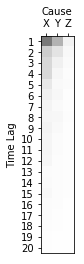

Calculated causes to Y(t)


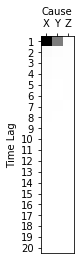

Calculated causes to Z(t)


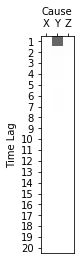

In [305]:
causality_heatmap(W_ex1, ex1, 'ind', 2)

###  Example 2

In [272]:
MAX_LAG = 20
ex2 = generate_ex2(1000).iloc[:, :3]

In [258]:
W_ex2 = NN_causality(ex2, lambda_=np.exp(0), reg_type='h', max_lag=MAX_LAG, batch_size=100)

Computing causality of X (variable 1 of 3)...
Computing causality of Y (variable 2 of 3)...
Computing causality of Z (variable 3 of 3)...


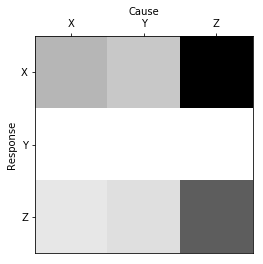

In [259]:
causality_heatmap(W_ex2, ex2, 'joint', 2)

Calculated causes to X(t)


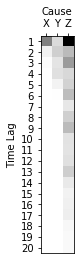

Calculated causes to Y(t)


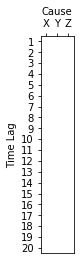

Calculated causes to Z(t)


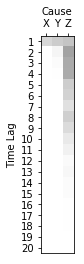

In [260]:
causality_heatmap(W_ex2, ex2, 'ind', 2)

In [262]:
MAX_LAG = 20
ex2 = generate_ex2(1000, int(datetime.datetime.now().timestamp())).iloc[:, :3]

In [263]:
W_ex2 = NN_causality(ex2, lambda_=np.exp(-2), reg_type='h', max_lag=MAX_LAG, batch_size=100)

Computing causality of X (variable 1 of 3)...
Computing causality of Y (variable 2 of 3)...
Computing causality of Z (variable 3 of 3)...


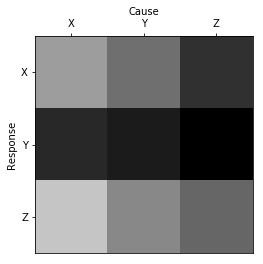

In [264]:
causality_heatmap(W_ex2, ex2, 'joint', 2)

Calculated causes to X(t)


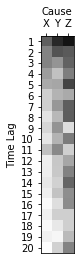

Calculated causes to Y(t)


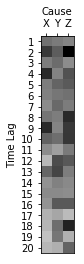

Calculated causes to Z(t)


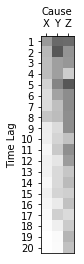

In [265]:
causality_heatmap(W_ex2, ex2, 'ind', 2)

In [266]:
MAX_LAG = 20
ex2 = generate_ex2(1000).iloc[:, :3]

Computing causality of X (variable 1 of 3)...
Computing causality of Y (variable 2 of 3)...
Computing causality of Z (variable 3 of 3)...


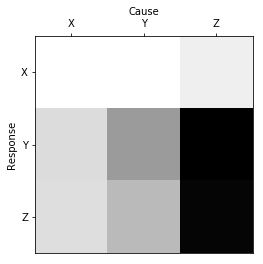

Computing causality of X (variable 1 of 3)...
Computing causality of Y (variable 2 of 3)...
Computing causality of Z (variable 3 of 3)...


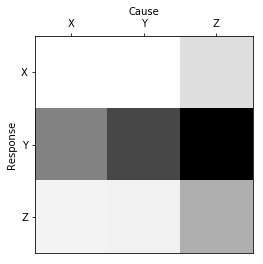

Computing causality of X (variable 1 of 3)...
Computing causality of Y (variable 2 of 3)...
Computing causality of Z (variable 3 of 3)...


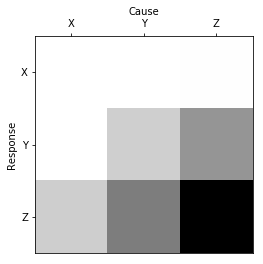

Computing causality of X (variable 1 of 3)...
Computing causality of Y (variable 2 of 3)...
Computing causality of Z (variable 3 of 3)...


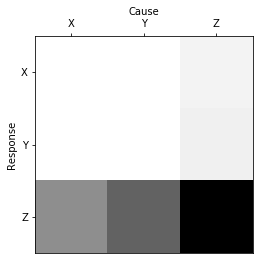

Computing causality of X (variable 1 of 3)...
Computing causality of Y (variable 2 of 3)...
Computing causality of Z (variable 3 of 3)...


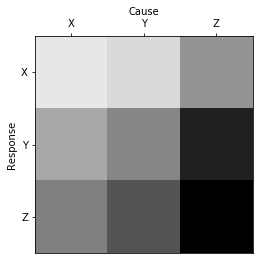

In [284]:
# 2 layer
lambdas_ = range(-6, 4, 2)
for lambda_ in lambdas_:
    W_ex2 = NN_causality(ex2, lambda_=np.exp(0), reg_type='h', max_lag=MAX_LAG, batch_size=100)
    causality_heatmap(W_ex2, ex2, 'joint')
    plt.pause(0.001)

In [286]:
MAX_LAG = 20
ex2 = generate_ex2(1000).iloc[:, :3]

Computing causality of X (variable 1 of 3)...
Computing causality of Y (variable 2 of 3)...
Computing causality of Z (variable 3 of 3)...


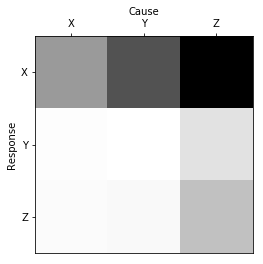

Computing causality of X (variable 1 of 3)...
Computing causality of Y (variable 2 of 3)...
Computing causality of Z (variable 3 of 3)...


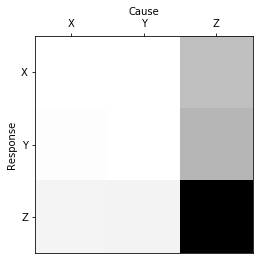

Computing causality of X (variable 1 of 3)...
Computing causality of Y (variable 2 of 3)...
Computing causality of Z (variable 3 of 3)...


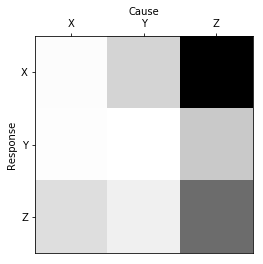

Computing causality of X (variable 1 of 3)...
Computing causality of Y (variable 2 of 3)...
Computing causality of Z (variable 3 of 3)...


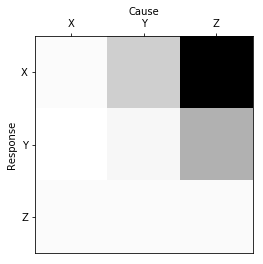

Computing causality of X (variable 1 of 3)...
Computing causality of Y (variable 2 of 3)...
Computing causality of Z (variable 3 of 3)...


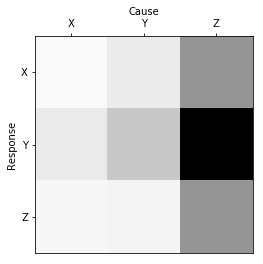

In [287]:
# 1 layer
lambdas_ = range(-6, 4, 2)
for lambda_ in lambdas_:
    W_ex2 = NN_causality(ex2, lambda_=np.exp(0), reg_type='h', max_lag=MAX_LAG, batch_size=100)
    causality_heatmap(W_ex2, ex2, 'joint')
    plt.pause(0.001)

Computing causality of X (variable 1 of 3)...
Computing causality of Y (variable 2 of 3)...
Computing causality of Z (variable 3 of 3)...


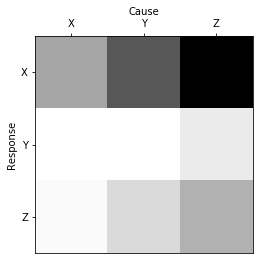

Computing causality of X (variable 1 of 3)...
Computing causality of Y (variable 2 of 3)...
Computing causality of Z (variable 3 of 3)...


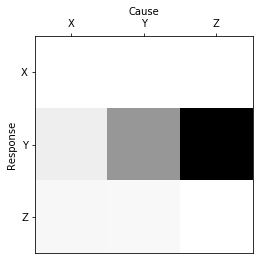

Computing causality of X (variable 1 of 3)...
Computing causality of Y (variable 2 of 3)...
Computing causality of Z (variable 3 of 3)...


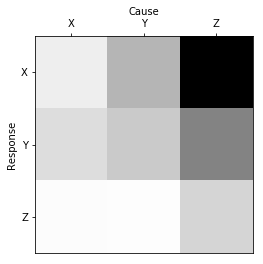

Computing causality of X (variable 1 of 3)...
Computing causality of Y (variable 2 of 3)...
Computing causality of Z (variable 3 of 3)...


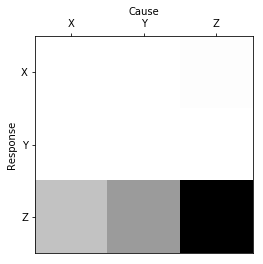

Computing causality of X (variable 1 of 3)...
Computing causality of Y (variable 2 of 3)...
Computing causality of Z (variable 3 of 3)...


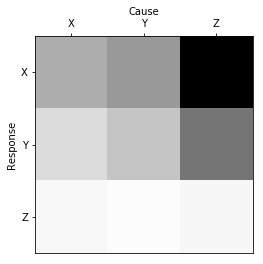

In [290]:
# 2 layer hL1
lambdas_ = range(-6, 4, 2)
for lambda_ in lambdas_:
    W_ex2 = NN_causality(ex2, lambda_=np.exp(0), reg_type='hL1', max_lag=MAX_LAG, batch_size=100)
    causality_heatmap(W_ex2, ex2, 'joint')
    plt.pause(0.001)

Computing causality of X (variable 1 of 3)...
Computing causality of Y (variable 2 of 3)...
Computing causality of Z (variable 3 of 3)...


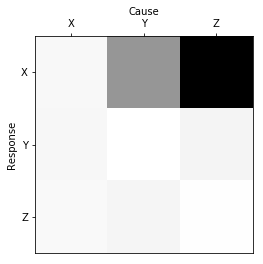

Computing causality of X (variable 1 of 3)...
Computing causality of Y (variable 2 of 3)...
Computing causality of Z (variable 3 of 3)...


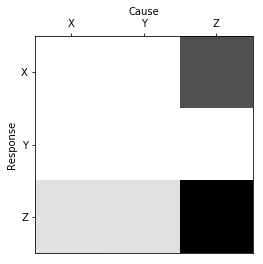

Computing causality of X (variable 1 of 3)...
Computing causality of Y (variable 2 of 3)...
Computing causality of Z (variable 3 of 3)...


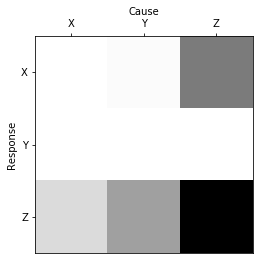

Computing causality of X (variable 1 of 3)...
Computing causality of Y (variable 2 of 3)...
Computing causality of Z (variable 3 of 3)...


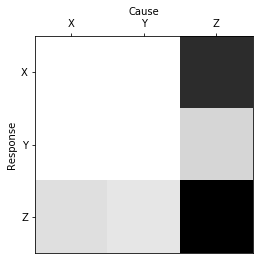

Computing causality of X (variable 1 of 3)...
Computing causality of Y (variable 2 of 3)...
Computing causality of Z (variable 3 of 3)...


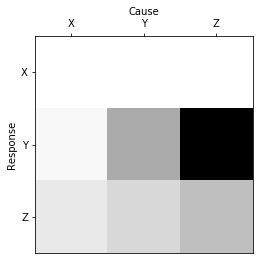

In [292]:
# 2 Layet

###  Example 3

In [206]:
MAX_LAG = 20
ex3 = generate_ex3()
ex3 = ex3[[x for x in ex3.columns if x in ['r1', 'r2', 'y1', 'y2']]]

In [246]:
generate_ex3().head()

,t,r1,r2,y1,y2,v
0,0.0,1.164954,0.979449,0.000000,0.368391,0.368391
1,0.1,0.626839,-0.265611,1.426526,1.624750,0.198224
2,0.2,0.075080,-0.548373,-1.370461,-0.653462,0.023742
3,0.3,0.351607,-0.096268,-0.917987,-0.099930,0.111188
4,0.4,-0.696513,-1.380671,-0.642339,-0.388362,-0.220257


In [207]:
W_ex3 = NN_causality(ex3, lambda_=np.exp(-2), reg_type='h', max_lag=MAX_LAG, batch_size=100)

Computing causality of r1 (variable 1 of 4)...
Computing causality of r2 (variable 2 of 4)...
Computing causality of y1 (variable 3 of 4)...
Computing causality of y2 (variable 4 of 4)...


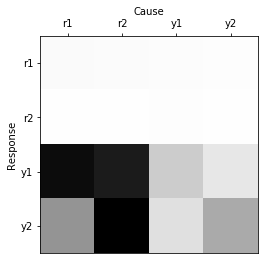

In [239]:
causality_heatmap(W_ex3, ex3, 'joint', 2)

Calculated causes to r1(t)


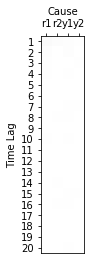

Calculated causes to r2(t)


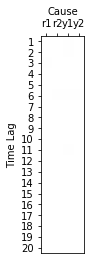

Calculated causes to y1(t)


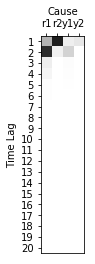

Calculated causes to y2(t)


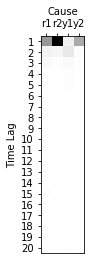

In [240]:
causality_heatmap(W_ex3, ex3, 'ind', 2)

### Test Playground

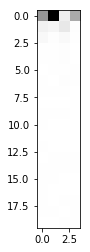

In [148]:
training_epochs = 2000
batch_size = 100
lambdas_ = range(-4, 5, 2)

for lambda_ in [-2]:
    tf.reset_default_graph()

    with tf.Session() as sess:
        _X, _Y, W1, optimizer = build_FCNN(X[0].shape, np.exp(lambda_), 'h')

        tf.global_variables_initializer().run()

        for epoch in range(training_epochs):
            for batch in range(len(X) // batch_size):
                sess.run([optimizer], feed_dict={
                    _X: X[(batch * batch_size):((batch + 1) * batch_size)], 
                    _Y: Y[(batch * batch_size):((batch + 1) * batch_size)][:, np.newaxis]
                })
        W1_ = sess.run(W1)

        var_heatmap(W1_)